In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
tf.test.is_built_with_cuda()
import os, sys
sys.path.append('../')
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import pyarrow.parquet as pq

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from datasets import WindowedGaitDataset, ToTensor
from gait_transformer import GaitTransformer, unscale_kinematics, unscale_gait_state, scale_gait_state
from gait_kinematics_model import GaitModel

import random
# Set the seed value all over the place to make this reproducible.
seed_val = 42


random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)




2023-02-03 05:39:20.315951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 05:39:21.821057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-02-03 05:39:21.821232: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [3]:
#RUN THIS ON COLAB
ON_COLAB = False
if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    drive_path = '/content/drive/MyDrive/Phase ML Data/'

In [3]:
!gsutil cp -r gs://ml_gait_estimation/r01_ordered_corrupt_time.csv .

Copying gs://ml_gait_estimation/r01_ordered_corrupt_time.csv...
- [1 files][301.3 MiB/301.3 MiB]                                                
Operation completed over 1 objects/301.3 MiB.                                    


In [4]:
!gsutil cp -r gs://ml_gait_estimation/r01_randomized_corrupt_time.csv .

Copying gs://ml_gait_estimation/r01_randomized_corrupt_time.csv...
\ [1 files][301.6 MiB/301.6 MiB]                                                
Operation completed over 1 objects/301.6 MiB.                                    


In [5]:
!gsutil cp -r gs://ml_gait_estimation/dataport_ordered_corrupt_time.csv .

Copying gs://ml_gait_estimation/dataport_ordered_corrupt_time.csv...
/ [1 files][506.4 MiB/506.4 MiB]                                                
Operation completed over 1 objects/506.4 MiB.                                    


In [6]:
!gsutil cp -r gs://ml_gait_estimation/dataport_randomized_corrupt_time.csv .

Copying gs://ml_gait_estimation/dataport_randomized_corrupt_time.csv...
| [1 files][507.1 MiB/507.1 MiB]                                                
Operation completed over 1 objects/507.1 MiB.                                    


In [7]:
!gsutil cp -r gs://ml_gait_estimation/gt_ordered_corrupt_time.csv .

Copying gs://ml_gait_estimation/gt_ordered_corrupt_time.csv...
\ [1 files][558.0 MiB/558.0 MiB]                                                
Operation completed over 1 objects/558.0 MiB.                                    


In [8]:
!gsutil cp -r gs://ml_gait_estimation/gt_randomized_corrupt_time.csv .

Copying gs://ml_gait_estimation/gt_randomized_corrupt_time.csv...
| [1 files][558.3 MiB/558.3 MiB]                                                
Operation completed over 1 objects/558.3 MiB.                                    


In [4]:
window_size = 150
meas_scale = np.array([[-69.35951035,  27.62815047],\
                        [-456.18013759,  401.13782617],\
                        [-63.71649984,  22.06632622],\
                        [-213.4786175,   396.93801619],\
                        [-35.26603985,  20.78473636],\
                        [-20.95456523,  14.63961137],\
                          [0,1]])

speed_scale = (0,2)
incline_scale = (-10,10)
stair_height_scale = (-0.2,0.2)

filename_dataport_ordered = 'dataport_ordered_stairs_label_corrupt_time.csv'
filename_dataport_randomized = 'dataport_randomized_stairs_label_corrupt_time.csv'

filename_r01_ordered = 'r01_ordered_stairs_label_corrupt_time.csv'
filename_r01_randomized = 'r01_randomized_stairs_label_corrupt_time.csv'

filename_gt_ordered = 'gt_ordered_stairs_label_corrupt_time.csv'
filename_gt_randomized = 'gt_randomized_stairs_label_corrupt_time.csv'

if ON_COLAB:
    filename_r01_ordered = drive_path+filename_r01_ordered
    filename_r01_randomized = drive_path+filename_r01_randomized
    filename_dataport_ordered = drive_path+filename_dataport_ordered
    filename_dataport_randomized = drive_path+filename_dataport_randomized
    filename_gt_ordered = drive_path+filename_gt_ordered
    filename_gt_randomized = drive_path+filename_gt_randomized
    

DO_DECIMATION = not True
if DO_DECIMATION:
    gait_data_r01_randomized = pd.read_csv(filename_r01_randomized, nrows=10000)
    gait_data_r01_ordered = pd.read_csv(filename_r01_ordered, nrows=10000)
    gait_data_dataport_ordered = pd.read_csv(filename_dataport_ordered, nrows=10000)
    gait_data_dataport_randomized = pd.read_csv(filename_dataport_randomized, nrows=10000)
    gait_data_gt_ordered = pd.read_csv(filename_gt_ordered, nrows=10000)
    gait_data_gt_randomized = pd.read_csv(filename_gt_randomized, nrows=10000)

    
else:
    gait_data_r01_randomized = pd.read_csv(filename_r01_randomized)
    gait_data_r01_ordered = pd.read_csv(filename_r01_ordered)
    gait_data_dataport_ordered = pd.read_csv(filename_dataport_ordered)
    gait_data_dataport_randomized = pd.read_csv(filename_dataport_randomized)
    gait_data_gt_ordered = pd.read_csv(filename_gt_ordered)
    gait_data_gt_randomized = pd.read_csv(filename_gt_randomized)


# REMOVE RANDOM SUBJECTS FOR X-VALIDATION
#FROM R01, remove two: AB02 and AB06
#FROM DATAPORT, remove three: AB09, AB05, and AB10
#FROM GT, remove six, AB25, AB28, AB30, AB20, AB12, AB09
REMOVE_SUBS_XVAL = True

if REMOVE_SUBS_XVAL:
    #r01 ordered
    index_sub_remove_r01 = gait_data_r01_ordered[ (gait_data_r01_ordered['subj_id'] == 2) | (gait_data_r01_ordered['subj_id'] == 6) ].index
    gait_data_r01_ordered_val = gait_data_r01_ordered.iloc[index_sub_remove_r01]
    gait_data_r01_ordered.drop(index_sub_remove_r01 , inplace=True)
    
    #r01 randomized
    index_sub_remove_r01 = gait_data_r01_randomized[ (gait_data_r01_randomized['subj_id'] == 2) | (gait_data_r01_randomized['subj_id'] == 6) ].index
    gait_data_r01_randomized_val = gait_data_r01_randomized.iloc[index_sub_remove_r01]
    gait_data_r01_randomized.drop(index_sub_remove_r01 , inplace=True)
    
    print(gait_data_r01_ordered.head())
    print(gait_data_r01_ordered_val.head())
    
    #dataport ordered
    index_sub_remove_dataport = gait_data_dataport_ordered[ (gait_data_dataport_ordered['subj_id'] == 9) | 
                                                           (gait_data_dataport_ordered['subj_id'] == 5) |
                                                          (gait_data_dataport_ordered['subj_id'] == 10)].index

    gait_data_dataport_ordered_val = gait_data_dataport_ordered.iloc[index_sub_remove_dataport]
    gait_data_dataport_ordered.drop(index_sub_remove_dataport , inplace=True)
    
    #dataport randomized
    index_sub_remove_dataport = gait_data_dataport_randomized[ (gait_data_dataport_randomized['subj_id'] == 9) | 
                                                           (gait_data_dataport_randomized['subj_id'] == 5) |
                                                          (gait_data_dataport_randomized['subj_id'] == 10)].index

    gait_data_dataport_randomized_val = gait_data_dataport_randomized.iloc[index_sub_remove_dataport]
    gait_data_dataport_randomized.drop(index_sub_remove_dataport , inplace=True)
    
    #gt ordered
    index_sub_remove_gt = gait_data_gt_ordered[ (gait_data_gt_ordered['subj_id'] == 25) | 
                                               (gait_data_gt_ordered['subj_id'] == 28) |
                                              (gait_data_gt_ordered['subj_id'] == 30) |
                                              (gait_data_gt_ordered['subj_id'] == 20) |
                                              (gait_data_gt_ordered['subj_id'] == 12) |
                                              (gait_data_gt_ordered['subj_id'] == 9)].index
    
    gait_data_gt_ordered_val = gait_data_gt_ordered.iloc[index_sub_remove_gt]
    gait_data_gt_ordered.drop(index_sub_remove_gt , inplace=True)
    
    #gt randomized
    index_sub_remove_gt = gait_data_gt_randomized[ (gait_data_gt_randomized['subj_id'] == 25) | 
                                               (gait_data_gt_randomized['subj_id'] == 28) |
                                              (gait_data_gt_randomized['subj_id'] == 30) |
                                              (gait_data_gt_randomized['subj_id'] == 20) |
                                              (gait_data_gt_randomized['subj_id'] == 12) |
                                              (gait_data_gt_randomized['subj_id'] == 9)].index
    
    gait_data_gt_randomized_val = gait_data_gt_randomized.iloc[index_sub_remove_gt]
    gait_data_gt_randomized.drop(index_sub_remove_gt , inplace=True)
    
    #concatenate
    gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized,\
                          gait_data_dataport_ordered, gait_data_dataport_randomized,\
                          gait_data_gt_ordered, gait_data_gt_randomized])
    
    gait_data_val = pd.concat([gait_data_r01_ordered_val, gait_data_r01_randomized_val,\
                              gait_data_dataport_ordered_val, gait_data_dataport_randomized_val,\
                              gait_data_gt_ordered_val, gait_data_gt_randomized_val])
    
    train_dataset = WindowedGaitDataset(gait_data=gait_data,
                                                meas_scale=meas_scale,
                                                window_size = window_size,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                stair_height_scale=stair_height_scale,
                                                transform=ToTensor())
    
    val_dataset = WindowedGaitDataset(gait_data=gait_data_val,
                                                meas_scale=meas_scale,
                                                window_size = window_size,
                                                speed_scale = speed_scale,
                                                incline_scale = incline_scale,
                                                stair_height_scale=stair_height_scale,
                                                transform=ToTensor())
    
    print('{:>5,} training samples'.format(len(train_dataset)))
    print('{:>5,} validation samples'.format(len(val_dataset)))


else:
    gait_data = pd.concat([gait_data_r01_ordered, gait_data_r01_randomized,\
                          gait_data_dataport_ordered, gait_data_dataport_randomized,\
                          gait_data_gt_ordered, gait_data_gt_randomized])
    # gait_data = gait_data_r01_randomized
    # gait_data = pd.concat([gait_data_r01_randomized, gait_data_dataport_randomized])
    
    dataset = WindowedGaitDataset(gait_data=gait_data,
                                            meas_scale=meas_scale,
                                            window_size = window_size,
                                            speed_scale = speed_scale,
                                            incline_scale = incline_scale,
                                            stair_height_scale=stair_height_scale,
                                            transform=ToTensor())  
    # Create a 90-10 train-validation split.

    # Calculate the number of samples to include in each set.
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size


    # Divide the dataset by randomly selecting samples.
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    print('{:>5,} training samples'.format(train_size))
    print('{:>5,} validation samples'.format(val_size))

print(val_dataset[0]['meas'][-1,:])
print(val_dataset[1]['meas'][-1,:])
print(val_dataset[2]['meas'][-1,:])






   foot_angle  foot_vel_angle  shank_angle  shank_vel_angle  heel_acc_forward  \
0    9.713109     -122.000000     6.810365       -54.155000          0.000000   
1    7.928249     -133.739183     5.993880       -61.785706         -3.391320   
2    7.120444     -147.077747     5.606053       -70.516308         -7.078094   
3    5.217823     -162.450106     4.621966       -84.205665         -3.548601   
4    3.440199     -167.100286     3.626258       -93.718654         -1.555049   

   heel_acc_upward     phase  speed  incline  stair_height  is_moving  \
0         0.000000  0.000968    0.8    -10.0           0.0        1.0   
1         2.057084  0.013282    0.8    -10.0           0.0        1.0   
2         4.304541  0.018221    0.8    -10.0           0.0        1.0   
3         2.657375  0.028783    0.8    -10.0           0.0        1.0   
4         1.422208  0.038366    0.8    -10.0           0.0        1.0   

   stride_count  HSDetected  subj_id        dt      time  
0             1

In [5]:
#Test model
test_dataset = val_dataset

BATCH_SIZE = 1024*4

#it's important we don't shuffle in this dataloader
prediction_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False,num_workers=8)
# Prediction on test set

print('Predicting labels for {:,} test points...'.format(len(test_dataset)))

# SET UP GAIT MODEL
dim_val = 64 # 
n_hidden_layers=4
input_size = 6 # The number of input variables. 1 if univariate forecasting.
num_predicted_features = 6 # The number of output variables. 
# )

best_model = GaitModel(
    input_size=input_size,
    num_predicted_features=num_predicted_features,
    dim_val=dim_val,  
    n_hidden_layers=n_hidden_layers
)


if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")


if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
best_model.to(device)


model_nickname = 'gait-model'

model_dir = f'../full_models/{model_nickname}/model_save/'
if REMOVE_SUBS_XVAL:
    model_dir = f'../full_models/{model_nickname}/model_save_xval/'

checkpoint = torch.load(model_dir+'best_gait_model.tar')
g = checkpoint['model_state_dict']
loss = checkpoint['loss']
print(f'Lowest Loss: {loss}')
best_model.load_state_dict(g)

epoch = checkpoint['epoch']

# Put model in evaluation mode
best_model.eval()


#Set up start of sequence token
SOS_token = 100 * torch.ones(1, 1, num_predicted_features).to(device).requires_grad_(False)

# Tracking variables 
predictions , true_labels = [], []

phases = np.zeros((len(prediction_dataloader.dataset),))
print(phases.shape)

#set up covariance 
covariances = np.zeros((len(test_dataset),num_predicted_features,num_predicted_features))
print(covariances.shape)


#Extract index for time steps
DT_IDX = 6

# Predict
cov_idx = 0
for i, batch in enumerate(prediction_dataloader):

    b_kinematics = batch['meas'].to(device)
    b_state = batch['state'].to(device)
    # tgt_gait_estimator = SOS_token_gait_estimator.repeat(b_state.shape[0], 1, 1)
    # tgt = SOS_token.repeat(b_state.shape[0], 1, 1)
    dts = b_kinematics[:,:,DT_IDX]
    dts = torch.unsqueeze(dts, dim=-1)
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        
        # Forward pass through the gait estimator, calculate gait state predictions
        # predicted_gait_state = best_estimator(b_kinematics,tgt_gait_estimator, dts)
        # print(predicted_gait_state)
        
        #Run the confidence model
        #extract only the last (most recent temporally) element of the kinematics
        b_kinematics = b_kinematics[:,-1,:-1]

        outputs = best_model(b_state)

    # Move logits and labels to CPU
    outputs = outputs.detach().to('cpu').numpy()
    b_kinematics = b_kinematics.to('cpu').numpy()
    b_state = b_state.to('cpu').numpy()
  
    # Store predictions and true labels
    outputs = np.squeeze(outputs, axis=1)
    
    # print(outputs.shape)
    
    #unscale
    outputs = unscale_kinematics(outputs, meas_scale)
    b_kinematics = unscale_kinematics(b_kinematics, meas_scale)
    
    #unscale gait state
    b_state = unscale_gait_state(np.squeeze(b_state, axis=1), speed_scale, incline_scale, stair_height_scale)
    
    
    #compute covariances
    diff_kinematics = outputs - b_kinematics
    diff_kinematics = np.expand_dims(diff_kinematics, axis=1)
    
    # covariances_batch = np.transpose(diff_kinematics,(0,2,1)) @ 
    # print(diff_kinematics.shape)
    # print(np.transpose(diff_kinematics,(0,2,1)).shape)
    covariances_batch = np.einsum('ijk,ikl->ijl', np.transpose(diff_kinematics,(0,2,1)), diff_kinematics)
    # print(covariances_batch.shape)
    batch_size = covariances_batch.shape[0]
    
    #update main array of covariances
    covariances[cov_idx:cov_idx+batch_size,:,:] = covariances_batch
    
    #update phases
    phases[cov_idx:cov_idx+batch_size] = b_state[:,0]
    
    cov_idx += batch_size
    
    # Store predictions and true labels
    predictions.extend(outputs.tolist())
    true_labels.extend(b_kinematics.tolist())

print('    DONE PREDICTING')

Predicting labels for 4,477,713 test points...
Using GPU.
Lowest Loss: 0.035824309887171175
(4477713,)
(4477713, 6, 6)
    DONE PREDICTING


Avg Covariance: [[ 6.58809785e+01  1.01267729e+01  4.27249203e+01  2.28993785e+01
   4.52364890e-01  4.95876637e+00]
 [ 1.01267729e+01  5.53856868e+03 -7.56442126e+00  2.43133475e+03
   8.33002335e+00 -8.13652642e+00]
 [ 4.27249203e+01 -7.56442126e+00  5.11442276e+01  6.66311986e+00
  -2.93096428e+00  2.61970029e+00]
 [ 2.28993785e+01  2.43133475e+03  6.66311986e+00  2.39775414e+03
   3.02309431e+01  1.69325496e+01]
 [ 4.52364890e-01  8.33002335e+00 -2.93096428e+00  3.02309431e+01
   2.24791540e+01 -1.04929146e+00]
 [ 4.95876637e+00 -8.13652642e+00  2.61970029e+00  1.69325496e+01
  -1.04929146e+00  1.43192144e+01]]
Std Covariance: [[  256.51141243  1664.1397727    228.25479425  1380.9940242
     68.37344369    57.75042175]
 [ 1664.1397727  27675.0901901   1544.65804707 23699.57048022
    606.3286835    570.60940179]
 [  228.25479425  1544.65804707   228.73117056  1370.84965022
     55.09270191    47.15656745]
 [ 1380.9940242  23699.57048022  1370.84965022 22925.75619962
    390.1503800

<AxesSubplot:>

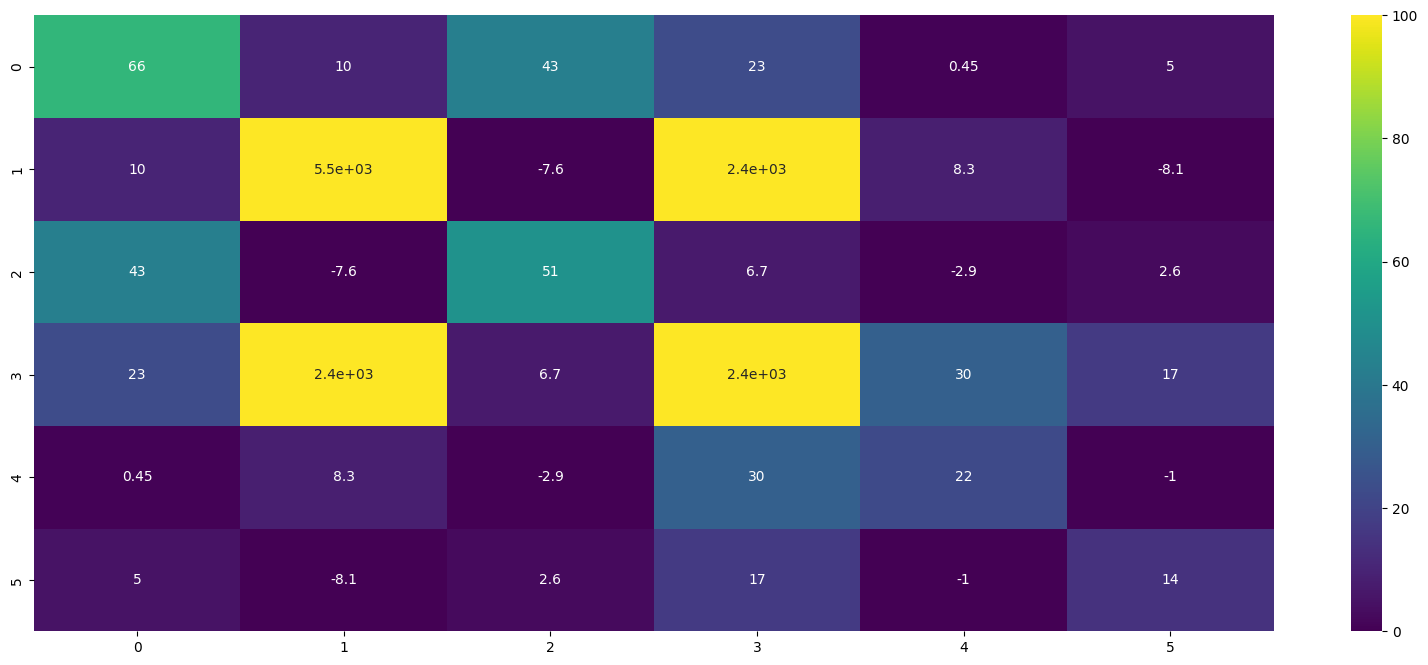

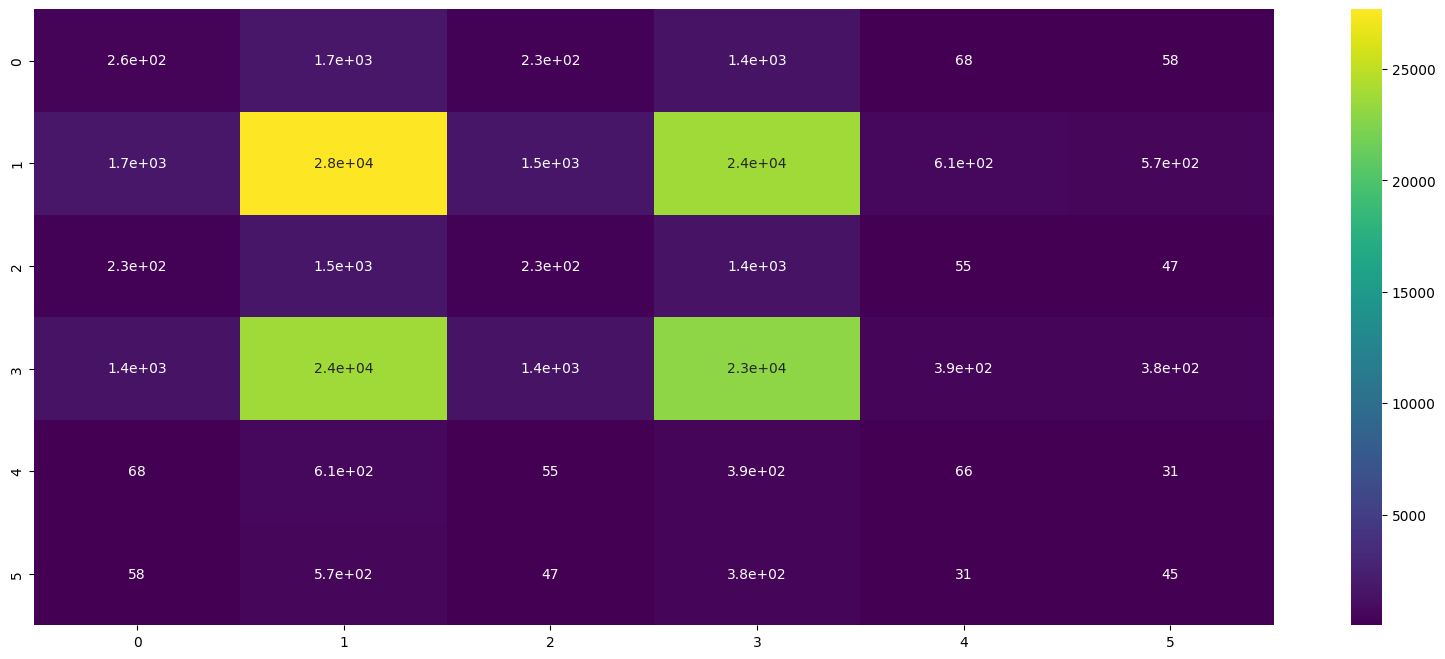

In [6]:
#compute average covariance

avg_covariance = np.average(covariances, axis=0)
std_covariance = np.std(covariances, axis=0)

print(f'Avg Covariance: {avg_covariance}')
print(f'Std Covariance: {std_covariance}')

import seaborn as sns
fig, axs = plt.subplots(figsize=(20,8),sharex=True)
sns.heatmap(avg_covariance,annot=True,cmap='viridis',vmin=0,vmax=100)

fig, axs = plt.subplots(figsize=(20,8),sharex=True)
sns.heatmap(std_covariance,annot=True,cmap='viridis')


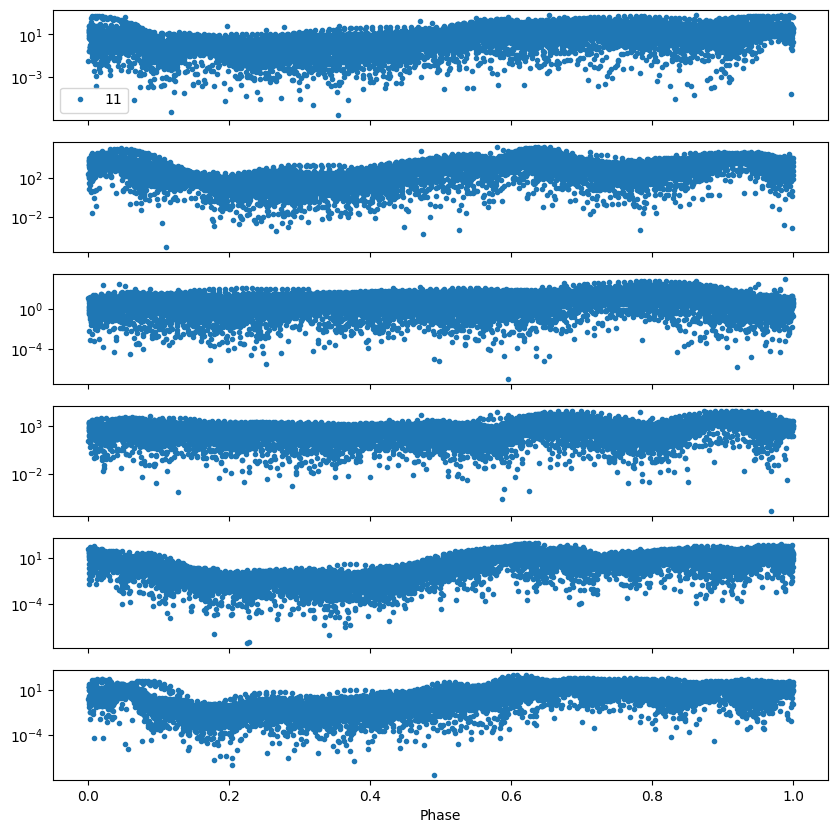

In [7]:
N_PLOT = 10000
cov_vec_11 = covariances[:N_PLOT,0,0]
cov_vec_22 = covariances[:N_PLOT,1,1]
cov_vec_33 = covariances[:N_PLOT,2,2]
cov_vec_44 = covariances[:N_PLOT,3,3]
cov_vec_55 = covariances[:N_PLOT,4,4]
cov_vec_66 = covariances[:N_PLOT,5,5]

phase_vec = phases[:N_PLOT]


fig, axs = plt.subplots(6,1,figsize=(10,10),sharex=True)

axs[0].plot(phase_vec, cov_vec_11,'.',label='11')
axs[0].legend()
axs[1].plot(phase_vec, cov_vec_22,'.',label='22')

axs[2].plot(phase_vec, cov_vec_33,'.',label='33')
axs[3].plot(phase_vec, cov_vec_44,'.',label='44')
axs[4].plot(phase_vec, cov_vec_55,'.',label='55')
axs[5].plot(phase_vec, cov_vec_66,'.',label='66')
axs[-1].set_xlabel('Phase')

axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')
axs[3].set_yscale('log')
axs[4].set_yscale('log')
axs[5].set_yscale('log')


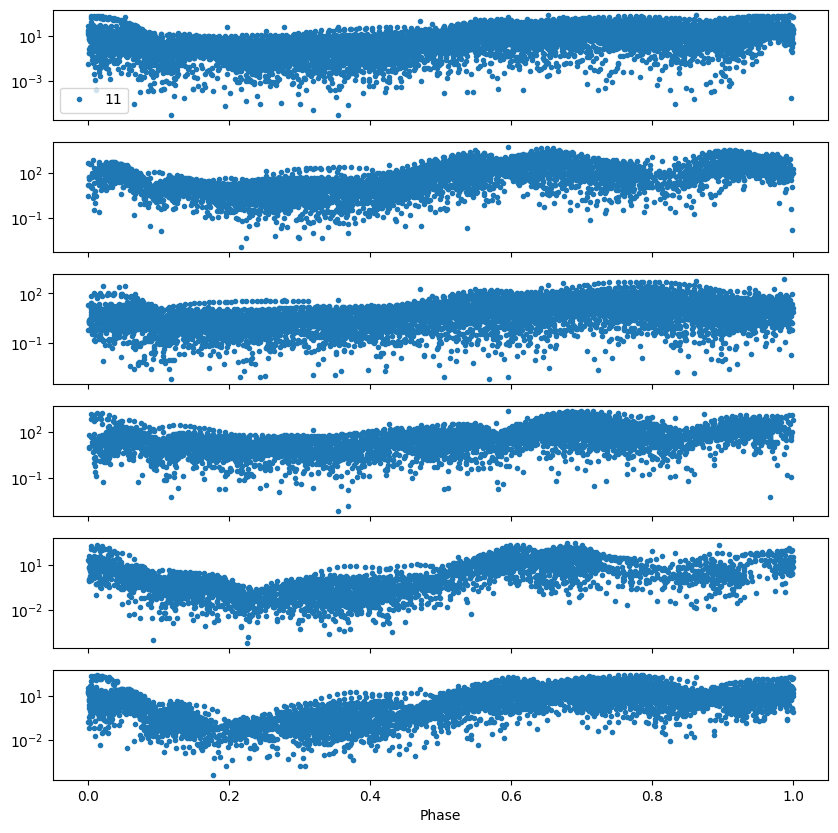

In [50]:
N_PLOT = 10000
cov_vec_11 = covariances[:N_PLOT,0,0]
cov_vec_12 = covariances[:N_PLOT,0,1]
cov_vec_13 = covariances[:N_PLOT,0,2]
cov_vec_14 = covariances[:N_PLOT,0,3]
cov_vec_15 = covariances[:N_PLOT,0,4]
cov_vec_16 = covariances[:N_PLOT,0,5]

phase_vec = phases[:N_PLOT]


fig, axs = plt.subplots(6,1,figsize=(10,10),sharex=True)

axs[0].plot(phase_vec, cov_vec_11,'.',label='11')
axs[0].legend()
axs[1].plot(phase_vec, cov_vec_12,'.',label='12')

axs[2].plot(phase_vec, cov_vec_13,'.',label='13')
axs[3].plot(phase_vec, cov_vec_14,'.',label='14')
axs[4].plot(phase_vec, cov_vec_15,'.',label='15')
axs[5].plot(phase_vec, cov_vec_16,'.',label='16')
axs[-1].set_xlabel('Phase')

axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')
axs[3].set_yscale('log')
axs[4].set_yscale('log')
axs[5].set_yscale('log')


[-4.60517019  6.59583506]
[-2.21500356 11.25173026]
[-4.60517019  8.00316999]



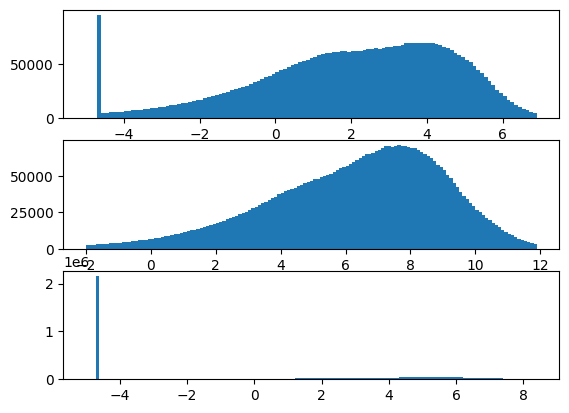

In [47]:
cov_floored = covariances.copy()
cov_floored[cov_floored<1e-2] = 1e-2
cov11 = cov_floored[:,0,0]
cov22 = cov_floored[:,1,1]
cov12 = cov_floored[:,0,1]

cov11_range = np.quantile(np.log(cov11), [0.01,0.99])
print(cov11_range)
cov22_range = np.quantile(np.log(cov22), [0.01,0.99])
print(cov22_range)
cov12_range = np.quantile(np.log(cov12), [0.01,0.99])
print(cov12_range)

fig, axs = plt.subplots(3,1)
axs[0].hist(np.log(cov11),bins=np.arange(-5,7,0.1))
axs[1].hist(np.log(cov22),bins=np.arange(-2,12,0.1))
axs[2].hist(np.log(cov12),bins=np.arange(-5,8.5,0.1))

print('')


In [48]:
N = 6
L = np.sum([i+1 for i in range(N)])
unique_covar_elements_scale = np.zeros((L,2))
idx = 0
for i in range(0,N):
    for j in range(i,N):
        # print(i,j)
        covars = cov_floored[:,i,j]
        cov_range = np.quantile(np.log(covars), [0.01,0.99])
        
        unique_covar_elements_scale[idx,0] = cov_range[0]
        unique_covar_elements_scale[idx,1] = cov_range[1]
        idx += 1
        
print(unique_covar_elements_scale)

[[-4.60517019  6.59583506]
 [-4.60517019  8.00316999]
 [-4.60517019  6.23502258]
 [-4.60517019  7.62349018]
 [-4.60517019  5.32510388]
 [-4.60517019  5.17364564]
 [-2.21500356 11.25173026]
 [-4.60517019  7.68459809]
 [-4.60517019 10.49797692]
 [-4.60517019  7.5181146 ]
 [-4.60517019  7.29806282]
 [-4.60517019  6.26124854]
 [-4.60517019  7.33407139]
 [-4.60517019  4.83793644]
 [-4.60517019  4.87319887]
 [-1.83459664 10.27920013]
 [-4.60517019  7.15667353]
 [-4.60517019  6.91650956]
 [-4.60517019  5.75253599]
 [-4.60517019  4.40803868]
 [-4.60517019  5.3568463 ]]


In [ ]:
predictions = np.array(predictions)
true_labels = np.array(true_labels)

#compute stds
foot_angle_std = np.sqrt(covariances[:,0,0])
print(foot_angle_std)
foot_angle_vel_std = np.sqrt(covariances[:,1,1])
shank_angle_std = np.sqrt(covariances[:,2,2])
shank_angle_vel_std = np.sqrt(covariances[:,3,3])
heel_acc_forward_std = np.sqrt(covariances[:,4,4])
heel_acc_up_std = np.sqrt(covariances[:,5,5])


#bound the accels at +- 100 to filter out the occasional spikes 
# predictions[:,4] = np.clip(predictions[:,4],-100,100)
# predictions[:,5] = np.clip(predictions[:,5],-100,100)

# true_labels[:,4] = np.clip(true_labels[:,4],-100,100)
# true_labels[:,5] = np.clip(true_labels[:,5],-100,100)



print(predictions.shape)
print(true_labels.shape)

foot_angle_losses = np.sqrt(np.mean((predictions[:,0] - true_labels[:,0])**2))
foot_angle_vel_losses = np.sqrt(np.mean((predictions[:,1] - true_labels[:,1])**2))
shank_angle_losses = np.sqrt(np.mean((predictions[:,2] - true_labels[:,2])**2))
shank_angle_vel_losses = np.sqrt(np.mean((predictions[:,3] - true_labels[:,3])**2))
heel_acc_forward_losses = np.sqrt(np.mean((predictions[:,4] - true_labels[:,4])**2))
heel_acc_up_losses = np.sqrt(np.mean((predictions[:,5] - true_labels[:,5])**2))


print("="*30)
# print(f'Foot Angle Losses: {np.mean(foot_angle_losses):.3f} +- {np.std(foot_angle_losses):.3f}')
# print(f'Foot Angle Vel Losses: {np.mean(foot_angle_vel_losses):.3f} +- {np.std(foot_angle_vel_losses):.3f}')
# print(f'Shank Angle Losses: {np.mean(shank_angle_losses):.3f} +- {np.std(shank_angle_losses):.3f}')
# print(f'Shank Angle Vel Losses: {np.mean(shank_angle_vel_losses):.3f} +- {np.std(shank_angle_vel_losses):.3f}')
# print(f'Heel Acc Forward Losses: {np.mean(heel_acc_forward_losses):.3f} +- {np.std(heel_acc_forward_losses):.3f}')
# print(f'Heel Acc Up Losses: {np.mean(heel_acc_up_losses):.3f} +- {np.std(heel_acc_up_losses):.3f}')

print(f'Foot Angle RMSE: {foot_angle_losses:.3f}')
print(f'Foot Angle Vel RMSE: {foot_angle_vel_losses:.3f}')
print(f'Shank Angle RMSE: {shank_angle_losses:.3f}')
print(f'Shank Angle Vel RMSE: {shank_angle_vel_losses:.3f}')
print(f'Heel Acc Forward RMSE: {heel_acc_forward_losses:.3f}')
print(f'Heel Acc Up RMSE: {heel_acc_up_losses:.3f}')


fig, axs = plt.subplots(6,1,figsize=(20,8),sharex=True)
# axs[0].set_xlim([9000,9500])
# axs[0].set_xlim([0.3622e6,0.3725e6]) #r01 randomized mix of stairs and inclines
# axs[0].set_xlim([2e6,2.0025e6]) #dataport mix of ramps
# axs[0].set_xlim([3.175e6,3.18e6]) #ordered gt
# axs[0].set_xlim([3.505e6,3.51e6]) #randomized gt
# axs[0].set_xlim([0.51575e6,0.516e6])

axs[0].plot(predictions[:,0],'r',label='predict')
# axs[0].plot(predictions[:,0]-1.96*foot_angle_std,'r--')
# axs[0].plot(predictions[:,0]+1.96*foot_angle_std,'r.')

axs[0].plot(true_labels[:,0],'b',label='actual')
axs[0].legend()

axs[0].set_ylabel('Foot Angle')
axs[0].set_ylim([-50,50])


axs[1].plot(predictions[:,1],'r',label='predict')
# axs[1].plot(predictions[:,1]-1.96*foot_angle_vel_std,'r--')
# axs[1].plot(predictions[:,1]+1.96*foot_angle_vel_std,'r.')
axs[1].plot(true_labels[:,1],'b',label='actual')
axs[1].set_ylabel('Foot Angle Vel')
axs[1].set_ylim([-500,600])


axs[2].plot(predictions[:,2],'r',label='predict')
# axs[2].plot(predictions[:,0]-1.96*shank_angle_std,'r--')
# axs[2].plot(predictions[:,0]+1.96*shank_angle_std,'r.')
axs[2].plot(true_labels[:,2],'b',label='actual')
axs[2].set_ylabel('Shank Angle')

axs[3].plot(predictions[:,3],'r',label='predict')
# axs[3].plot(predictions[:,3]-1.96*shank_angle_vel_std,'r--')
# axs[3].plot(predictions[:,3]+1.96*shank_angle_vel_std,'r.')
axs[3].plot(true_labels[:,3],'b',label='actual')
axs[3].set_ylabel('Shank Angle Vel')
axs[3].set_ylim([-1000,1000])


axs[4].plot(predictions[:,4],'r',label='predict')
# axs[4].plot(predictions[:,4]-1.96*heel_acc_forward_std,'r--')
# axs[4].plot(predictions[:,4]+1.96*heel_acc_forward_std,'r.')
axs[4].plot(true_labels[:,4],'b',label='actual')
axs[4].set_ylabel('Heel Acc Forward')
# axs[4].set_ylim([-50,50])


axs[5].plot(predictions[:,5],'r',label='predict')
# axs[5].plot(predictions[:,5]-1.96*heel_acc_up_std,'r--')
# axs[5].plot(predictions[:,5]+1.96*heel_acc_up_std,'r.')
axs[5].plot(true_labels[:,5],'b',label='actual')
axs[5].set_ylabel('Heel Acc Up')
# axs[5].set_ylim([-50,50])

#plot errors
fig, axs = plt.subplots(2,1,figsize=(20,8))
axs[0].hist(predictions[:,0] - true_labels[:,0], bins=100,label='foot ang errors')
axs[0].legend()
axs[1].hist(predictions[:,1] - true_labels[:,1], bins=100,label='foot ang errors')
axs[1].legend()
plt.show()


[5.96760559 8.34922028 4.9704628  ... 3.50366592 3.17526627 2.99072647]
(4477713, 6)
(4477713, 6)
Foot Angle RMSE: 8.117
Foot Angle Vel RMSE: 74.421
Shank Angle RMSE: 7.151
Shank Angle Vel RMSE: 48.967
Heel Acc Forward RMSE: 4.741
Heel Acc Up RMSE: 3.784


109.23353434140525
[0.30708354 1.65768701 3.15422877 6.88634472]


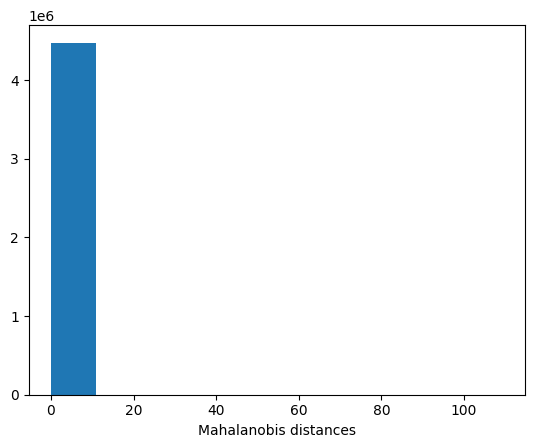

In [17]:
#plot mahalanobis distances
m_distances = np.zeros(foot_angle_std.shape)
C_inv = np.linalg.inv(avg_covariance)
for i in range(len(m_distances)):
    c = (predictions[i,:] - true_labels[i,:]).reshape(-1,1)
    m = np.sqrt(c.T @ C_inv @ c)
    m_distances[i] = m
    
fig, axs = plt.subplots()
axs.hist(m_distances, bins=10)
axs.set_xlabel('Mahalanobis distances')

percentiles = np.quantile(m_distances, [0.01, 0.5, 0.84, 0.99])
print(np.max(m_distances))
print(percentiles)